# Исследование надёжности заёмщиков

#### Тема проекта:
- Исследование надёжности заёмщиков, принадлежащих к различным социально-экономическим группам.  

#### Цель:
- Сделать предобработку данных и вывести информацию по доле должников для выделенных групп.

#### Поставленные задачи:
- Сделать предобработку данных:
   - Изучить пропуски, дубликаты, аномальные значения;
   - Провести лемматизацию целей кредита;
   - Сделать категоризацию для запрашиваемых групп.
- Сравнить группы, в зависимости от наличия детей, семейного статуса, целей кредита, группы дохода.
- По каждой группе вывести табличную и графическую информация по ситуации с должниками.

#### Краткий план работы:
- Шаг 1. Открытие и изучение файла;
- Шаг 2. Предобработка данных;
- Шаг 3. Вывод информации по группам.

#### Вывод:
- Проведена предобработа данных.
- Выведена информация по запрашиваемым социально-экономическим группам.

**Статус проекта**: проект завершён.

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *pymystem3*, *collections*

**Источник данных**: [курс Data Science от Яндекс.Практикум](https://praktikum.yandex.ru/profile/data-scientist/)

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функций для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from collections import Counter

## Шаг 1. Открытие и изучение файла

Выгрузим файл в датафрейм и посмотрим **общую информацию** по данным:

In [2]:
# загрузка файла
debt_raw = pd.read_csv('/datasets/data.csv')

# проверка общей информации
print(debt_raw.info())

# вывод первых строк
debt_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
None


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


- **Размер датафрейма**. В таблице содержится **21525 наблюдений** и **12 колонок** (различных признаков).
- **Пропущенные значения**. В колонках *days_employed* и *total_income* есть пропуски. Количество строк в этих колонках совпадает (19351 строк).
- **Тип данных**. На первый взгляд явных проблем нет (например, если бы *total_income* имел тип object). Но можно изменить тип данных *days_employed* (общий трудовой стаж в днях) на int64.

С данными в некоторых колонках видны явные проблемы даже в первых 10 строках:
 - Колонка **days_employed** - общий трудовой стаж в днях. Присутствуют **отрицательные** и **очень большие значения**. Так, в строке с индексом 4 есть значение 340266.072047 дней, т. е. 932 года.
 - Колонка **education** - явно есть проблемы с **регистром**.
 - Колонка **total_income** - в идеале, нужно уточнить валюту и округлить до 2 знаков после запятой.

Посмотрим, нет ли проблем в **наименовании колонок**: разный регистр, лишние пробелы и др.

In [3]:
# проверка названия колонок
debt_raw.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Все названия колонок указаны латиницей, маленькими буквами, без лишних пробелов. Названия можно оставить в текущем виде.

Проверим наши данные на предмет наличия **дубликатов**:

In [4]:
# подсчет количества задублированных строк
print('Количество дубликатов:', debt_raw.duplicated().sum())

# вывод нескольких строк
debt_raw[debt_raw.duplicated()].head()

Количество дубликатов: 54


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,NaN,41,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,покупка жилья для семьи
4182,1,NaN,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,NaN,свадьба
4851,0,NaN,60,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,свадьба
5557,0,NaN,58,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,сыграть свадьбу
7808,0,NaN,57,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,на проведение свадьбы


## Шаг 1. Вывод

Первые наблюдения при ознакомлении с данными:  

- Данные содержат **21525 наблюдений**, т.е. информацию по 21525 обращениям для займа, а также **12 колонок** - различные социально-экономические характеристики клиента и статус возврата долга.
- В таблице есть **пропущенные значения** в колонках *days_employed* и *total_income*. 
- На первый взгляд с **типом данных** нет явных проблем. Но, возможно, стоит изменить тип данных *days_employed* (общий трудовой стаж в днях) на int64.
- С **наименованиями колонок** явных проблем не обнаружено. Все названия указаны латиницей, маленькими буквами, без лишних пробелов.
- При первом ознакомлении в таблице есть **54 явных дубликата**. В разделе работы с дубликатами данные будут изучены более детально.

Есть дополнительные вопросы к значениям в колонках *days_employed*, *education*, *total_income*:
 - Колонка *days_employed* - общий трудовой стаж в днях. Присутствуют **отрицательные** и **очень большие значения**, которые вряд ли могут быть стажем в днях.
 - Колонка *education* - явно есть проблемы с **регистром**.
 - Колонка *total_income* - в идеале, нужно уточнить валюту и округлить до 2 знаков после запятой.

## Шаг 2. Предобработка данных

Предобработка данных будет состоять из следующих этапов:
- 2.1. Приведение данных к единому регистру
- 2.2. Проверка данных на правдоподобность
- 2.3. Обработка пропусков
- 2.4. Обработка дубликатов
- 2.5. Лемматизация значений *purpose*
- 2.6. Категоризация

### 2.1. Приведение данных к единому регистру

Ранее мы отметили, что даже в первых строках в некоторых колонках были **проблемы с регистром**.  

Сначала отдельно проверим значения в колонке *gender*:

In [5]:
# проверка значений
debt_raw['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Присутствуют значения **F** - женский пол, **M** - мужской пол.  
Также есть одно значение **XNA**, что, скорее всего, означает пропуск. Удалим данное наблюдение из датафрейма:

In [6]:
# создадим рабочую копию
debt = debt_raw.copy()

print('Количество строк ДО:', len(debt))
debt = debt[debt['gender'] != 'XNA']
debt.reset_index(inplace=True, drop=True)
print('Количество строк ПОСЛЕ:', len(debt))

Количество строк ДО: 21525
Количество строк ПОСЛЕ: 21524


Теоретически данную колонку можно перевести в **логический тип**, например, 0 - M, 1 - F. Но пока оставим данные в текущем виде.

Теперь исправим регистр в колонках типа object: *education*, *family_status*, *income_type*, *purpose*.

In [7]:
# изменение регистра для выбранных колонок
obj_columns = ['education', 'family_status', 'income_type', 'purpose']
for col_name in obj_columns:
    debt[col_name] = debt[col_name].str.lower()
    
debt.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Данные типа object приведены к нужному формату. Можем переходить к следующему пункту.

### 2.2. Проверка данных на правдоподобность

#### Колонка children

In [8]:
# колонка children
debt['children'].value_counts()

 0     14148
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Присутствуют некоторые подозрительные значения. Например, **отрицательное значение** - возможно, это ошибка либо обозначение пропуска.

Также в 76 случаях присутствует значение **20 детей**. В 2018 году семей с 11 и более детей [около 1000](https://www.virtualacademy.ru/news/statistika-kolichestva-detei-v-seme-v-rossii/). Вряд ли 7% этих семей имеют именно 20 детей и пришли именно в этот банк за кредитом.  

В реальной жизни по обоим случаям необходимо уточнить информацию. Для текущей задачи мы **исключим** эти данные из таблицы.

In [9]:
print('Количество строк ДО:', len(debt))
debt = debt[(debt['children'] != 20) & (debt['children'] != -1)]
debt.reset_index(inplace=True, drop=True)
print('Количество строк ПОСЛЕ:', len(debt))

Количество строк ДО: 21524
Количество строк ПОСЛЕ: 21401


#### Колонка dob_years

Проверим, присутствует ли в датафрейме возраст младше 18 лет и старше 75 лет:

In [10]:
# колонка dob_years
print(debt[(debt['dob_years'] < 18) | (debt['dob_years'] > 75)]['dob_years'].value_counts())
debt[(debt['dob_years'] < 18) | (debt['dob_years'] > 75)].head()

0    100
Name: dob_years, dtype: int64


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,346541.618895,0,среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,-2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,-1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
577,0,397856.565013,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1033,0,-1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль


Да, присутствует 100 строк с возрастом **0 лет**. Удалим данные строки из датафрейма:

In [11]:
print('Количество строк ДО:', len(debt))
debt = debt[debt['dob_years'] != 0]
debt.reset_index(inplace=True, drop=True)
print('Количество строк ПОСЛЕ:', len(debt))

Количество строк ДО: 21401
Количество строк ПОСЛЕ: 21301


#### Колонка education

In [12]:
# колонка education
debt['education'].value_counts()

среднее                15073
высшее                  5202
неоконченное высшее      738
начальное                282
ученая степень             6
Name: education, dtype: int64

Проблем и подозрительных значений нет. Проверим взаимное соответствие *education* и *education_id*:

In [13]:
# проверка взаимного соответствия
debt.groupby("education")["education_id"].unique()

education
высшее                 [0]
начальное              [3]
неоконченное высшее    [2]
среднее                [1]
ученая степень         [4]
Name: education_id, dtype: object

Всё в порядке, каждому типу образования соответствует один определённый id.

#### Колонка family_status

Поскольку у нас также присутствует колонка с id, сразу проверим колонки *family_status* и *family_status_id* на взаимное соответствие.

In [14]:
# проверка взаимного соответствия
debt.groupby("family_status")["family_status_id"].unique()

family_status
в разводе                [3]
вдовец / вдова           [2]
гражданский брак         [1]
женат / замужем          [0]
не женат / не замужем    [4]
Name: family_status_id, dtype: object

В колонках, связанных с семейным положением тоже всё в порядке.

#### Колонка income_type

In [15]:
# колонка income_type
debt['income_type'].value_counts()

сотрудник          10996
компаньон           5033
пенсионер           3819
госслужащий         1447
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

В данных содержится **8 категорий** для обозначения трудового статуса человека.

#### Колонка debt

In [16]:
# колонка income_type
debt['debt'].value_counts()

0    19577
1     1724
Name: debt, dtype: int64

Большинство клиентов банка **не являются должниками**.

#### Колонка total_income

count    1.914900e+04
mean     1.674919e+05
std      1.032220e+05
min      2.066726e+04
25%      1.030283e+05
50%      1.450179e+05
75%      2.033535e+05
max      2.265604e+06
Name: total_income, dtype: float64


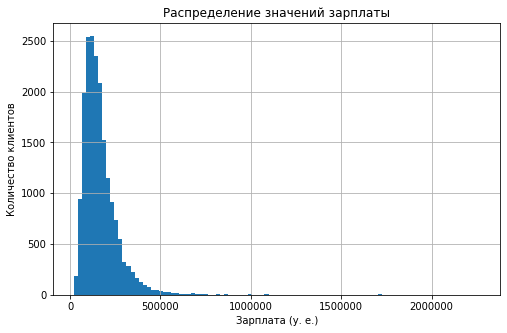

In [17]:
# вывод сводной статистики
print(debt['total_income'].describe())

# построение графика
plt.figure(figsize=(8, 5))
plt.hist(debt['total_income'], bins=100)
plt.title('Распределение значений зарплаты')
plt.xlabel('Зарплата (у. е.)')
plt.ylabel('Количество клиентов')
plt.grid()
plt.show()

- В данных наблюдается **положительная скошенность**, т. е. смещённость в сторону бóльших значений. 
- Выборочное **среднее** около **160 тыс. у. е.**, **медиана** - **145 тыс. у. е.** (валюта неизвестна, поэтому используем обозначение у. е.).
- **Минимальное** начение - около **20 тыс. у. е.**, **максимальное** - **2,2 млн у. е.**.

Итак, мы проверили значения практически во всех колонках. Колонка *days_employed* будет рассмотрена в следующем пункте.

### 2.3. Обработка пропусков

Посчитаем **количество пропусков** в колонках *days_employed* и *total_income*:

In [18]:
# вывод количества пропусков по колонкам
debt.isna().sum()

children               0
days_employed       2152
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2152
purpose                0
dtype: int64

Есть подозрение, что **пропуски** находятся **в одних и тех же строках**. Сделаем два датафрейма и сравним их: 
- **df_days_employed_nan** - где пропуски только в колонке *days_employed*
- **df_total_income_nan** - где пропуски только в колонке *total_income*

In [19]:
# пропуски только в days_employed
df_days_employed_nan = debt[debt['days_employed'].isna()]

# пропуски только в total_income
df_total_income_nan = debt[debt['total_income'].isna()]

# сравнение двух датафреймов
print('Два срезы идентичны: ', end='')
print(df_days_employed_nan.equals(df_total_income_nan))

Два срезы идентичны: True


Действительно, **пропуски** допущены в одних и тех же строках.

Есть несколько предварительных версий относительно **пропущенных значений** в обеих колонках *days_employed* (общий трудовой стаж в днях) и *total_income* (ежемесячный доход):
1. **Человек никогда официально не работал и не работает**. Поэтому данные по трудовому стажу и доходу отсутствуют. Значит, статус человека должен быть, например, "безработный"/"пенсионер"/"студент"/"в декрете".
2. **Отсутствие информации** по клиентам. Например, заемщики отказались предоставлять эту информацию о себе.
3. **Техническая причина**. Например, случайный пропуск в результате выгрузки. Данные были в исходном файле, но по какой-то причине не загрузились или не прочлись программой.
4. **Человеческого фактор**. Кто-то случайно стёр данные, некорректно заполнил базу и др.

**Первая причина** сразу же отвергается, потому что среди наблюдений с пропусками есть работающие люди, например, сотрудники и госслужащие:

In [20]:
print(df_total_income_nan['income_type'].value_counts())

сотрудник          1096
компаньон           502
пенсионер           407
госслужащий         146
предприниматель       1
Name: income_type, dtype: int64


**Вторая причина** - возможна, но маловероятна, т. к. данная информация существенна.

**Третья** и **четвёртая** причины связаны с **техническим** и **человеческим** фактором.  
Возможно, проблемы в данных связаны с некорректным заполнением базы или техническим сбоем.

Вспомним, что ещё при ознакомлении с данными нас смутили значения **колонки *days_employed***, где присутствуют **отрицательные** или **нереалистично большие** значения. В идеале, причину таких данных нужно уточнить у коллег, которые предоставили выгрузку.  
Для текущих задач можем **полностью удалить** колонку *days_employed*, т. к. в ней содержаться не только пропуски, но в принципе подозрительные данные.

In [21]:
# удаление колонки days_employed
debt = debt.drop('days_employed', axis=1)
debt.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Что касается колонки *total_income* - доля пропусков порядка **10%**:

In [22]:
print('Доля строк с пропусками в колонке total_income {:.2%}'.format(debt['total_income'].isnull().sum() / len(debt)))

Доля строк с пропусками в колонке total_income 10.10%


Теоретически можно было бы восстановить пропуск, заполнив его подходящей мерой центральной тенденции.  
Для этого необходимо разбить выборку на несколько групп и изучить распределение *total_income* выбранной группы. Однако такие замены способны смещать данные.

Поскольку пропусков относительно немного, мы примем решение **удалить** строки с неполной информацией.

In [23]:
print('Количество строк ДО:', len(debt))
debt.dropna(inplace=True)
print('Количество строк ПОСЛЕ:', len(debt))

Количество строк ДО: 21301
Количество строк ПОСЛЕ: 19149


### 2.4. Обработка дубликатов

Ранее мы уже проверяли данные: в них содержалось **54 дубликата**. Все эти дубликаты имели пропуски в колонках *days_employed* и*total_income*.  
Проверим, изменилось ли значение после приведения текстовых данных к единому регистру:

In [24]:
# подсчет количества задублированных строк
print('Количество дубликатов:', debt.duplicated().sum())

# вывод нескольких строк
debt[debt.duplicated()].head()

Количество дубликатов: 0


,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


В предыдущих пунктах предобработки вместе с неправдоподобными и пропущенными значениями были удалены и **дубликаты**.

### 2.5. Лемматизация

Бегло ознакомимся со значениями колонки *purpose*.  
Видим, что некоторые причины очень похожи и их можно объединить в **одну категорию**.

In [25]:
# выведем список причин и количество обращений по каждой
purposes = debt['purpose'].value_counts()
purposes

свадьба                                   716
сыграть свадьбу                           684
на проведение свадьбы                     677
операции с недвижимостью                  609
покупка коммерческой недвижимости         592
покупка жилья                             584
покупка жилья для сдачи                   584
жилье                                     579
операции с коммерческой недвижимостью     575
строительство жилой недвижимости          573
покупка своего жилья                      572
операции с жильем                         569
покупка жилья для семьи                   568
недвижимость                              568
строительство недвижимости                561
операции со своей недвижимостью           555
строительство собственной недвижимости    551
покупка недвижимости                      545
покупка жилой недвижимости                541
ремонт жилью                              538
на покупку своего автомобиля              449
автомобиль                        

Чтобы не выделять причины из списка вручную, воспользуемся **лемматизацией** и составим **частотнный словарь**.  
Для начала превратим содержимое массива в текст, чтобы применить к нему лемматизацию.

In [26]:
# задаем пустую string, в которую будем сохранять результат
text = ''

# получили массив ndarray с причинами
purposes = debt['purpose']

# сделаем итерацию по каждой фразе массива
for phrase in purposes:
    # в каждой фразе возьмем отдельные слова
    for word in phrase.split():
        # добавим лемматизированное слово в результат типа string
        text += word+' '

print(text)

покупка жилья приобретение автомобиля покупка жилья дополнительное образование сыграть свадьбу покупка жилья операции с жильем образование на проведение свадьбы покупка жилья для семьи покупка недвижимости покупка коммерческой недвижимости приобретение автомобиля покупка жилой недвижимости строительство собственной недвижимости недвижимость строительство недвижимости на покупку подержанного автомобиля на покупку своего автомобиля недвижимость приобретение автомобиля на покупку подержанного автомобиля сыграть свадьбу операции с коммерческой недвижимостью покупка недвижимости строительство собственной недвижимости строительство собственной недвижимости операции с коммерческой недвижимостью жилье на проведение свадьбы покупка жилья операции со своей недвижимостью на проведение свадьбы автомобили приобретение автомобиля образование заняться образованием покупка недвижимости получение образования приобретение автомобиля на покупку своего автомобиля заняться образованием сделка с подержанным

Теперь сделаем **лемматизацию** и составим **частотный словарь**:

In [27]:
# получим список с лемматизированными словами
m = Mystem()
lemma = m.lemmatize(text)
print(lemma)

['покупка', ' ', 'жилье', ' ', 'приобретение', ' ', 'автомобиль', ' ', 'покупка', ' ', 'жилье', ' ', 'дополнительный', ' ', 'образование', ' ', 'сыграть', ' ', 'свадьба', ' ', 'покупка', ' ', 'жилье', ' ', 'операция', ' ', 'с', ' ', 'жилье', ' ', 'образование', ' ', 'на', ' ', 'проведение', ' ', 'свадьба', ' ', 'покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', ' ', 'покупка', ' ', 'недвижимость', ' ', 'покупка', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'приобретение', ' ', 'автомобиль', ' ', 'покупка', ' ', 'жилой', ' ', 'недвижимость', ' ', 'строительство', ' ', 'собственный', ' ', 'недвижимость', ' ', 'недвижимость', ' ', 'строительство', ' ', 'недвижимость', ' ', 'на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', ' ', 'на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', ' ', 'недвижимость', ' ', 'приобретение', ' ', 'автомобиль', ' ', 'на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', ' ', 'сыграть', ' ', 'свадьба', ' ', 'операция', ' ', 'с', ' ', 'коммерческ

In [28]:
# получим частотный словарь
dict_freq = Counter(lemma)
print(dict_freq)

Counter({' ': 49093, 'недвижимость': 5670, 'покупка': 5301, 'жилье': 3994, 'автомобиль': 3851, 'образование': 3557, 'с': 2589, 'операция': 2308, 'свадьба': 2077, 'свой': 1996, 'на': 1992, 'строительство': 1685, 'высокий': 1229, 'получение': 1169, 'коммерческий': 1167, 'для': 1152, 'жилой': 1114, 'сделка': 836, 'дополнительный': 799, 'заниматься': 793, 'подержать': 758, 'сыграть': 684, 'проведение': 677, 'сдача': 584, 'семья': 568, 'со': 555, 'собственный': 551, 'ремонт': 538, 'приобретение': 415, 'профильный': 385, 'подержанный': 100, ' \n': 1})


На первый взгляд можно выделить следующие категории:
- Недвижимость
- Автомобиль
- Образование
- Операция
- Свадьба
- Строительство и ремонт

Проверим наши выделенные категории на адекватность описания целей кредита.  
Пропишем функцию, которая будет проверять необходимые нам слова.

In [29]:
purposes_unique = debt['purpose'].unique()

def check_word(*args):
    """Функция выводит лемматизированные цели с указанным словом:
    - *args - указать слова для поиска."""
    
    for word in args:
        print('Проверка слова', word)
        print('{:-<50}'.format(''))
        for phrase in purposes_unique:
            lemma_phrase = m.lemmatize(phrase)
            if word in lemma_phrase:
                print(lemma_phrase)
        print()

check_word('недвижимость', 'автомобиль', 'образование', 'операция', 'свадьба', 'строительство', 'ремонт')

Проверка слова недвижимость
--------------------------------------------------
['покупка', ' ', 'недвижимость', '\n']
['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']
['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n']
['недвижимость', '\n']
['строительство', ' ', 'недвижимость', '\n']
['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n']
['операция', ' ', 'с', ' ', 'недвижимость', '\n']
['строительство', ' ', 'жилой', ' ', 'недвижимость', '\n']

Проверка слова автомобиль
--------------------------------------------------
['приобретение', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']
['автомобиль', '\n']
['сделка', ' ', 'с', ' ', 'подержанный', ' ', 'автомобиль', '\n']
['автомобиль', '\n']
['свой', ' ', 'автомобиль', '\n']
['с

Видим проблемы:
- В некоторых целях содержатся **одновременно** слова **"недвижимость"** и **"строительство"**. Нужно учесть этот момент при категоризации. Необходимо, чтобы такие цели попадали в категорию **строительство**.
- Под словом **"операция"** имеется в виду не врачебное вмешательство, а сделки с недвижимостью. Поэтому данное слово можем **убрать** из списка категорий.

Финальный список категорий следующий:
- **Недвижимость** - различные операции с жилой и коммерческой недвижимостью (покупка, обмен и др.)
- **Автомобиль** - сделки, связанные с покупкой автомобиля
- **Образование** - получение образования
- **Свадьба** - проведение свадьбы
- **Строительство и ремонт** - действия по возведению или ремонту зданий и помещений

Определившись со списком категорий, сразу же проведем **категоризацию целей** и создадим нужные колонки.  
Напишем функцию для проведения категоризации целей:

In [30]:
# функция для категоризации целей
# "строительство" мы специально ставим перед словом "недвижимость",
# иначе функция не опознает эту категорию, т.к. при слове "недвижимость" будет TRUE и цикл закончится
def categorize_purpose(lemma_list):
    """Функция присваивает для цели одну из заранее определённых категорий."""
    if 'строительство' in lemma_list:
        return 'строительство и ремонт'
    elif 'ремонт' in lemma_list:
        return 'строительство и ремонт'
    elif 'недвижимость' in lemma_list:
        return 'недвижимость'
    elif 'жилье' in lemma_list:
        return 'недвижимость'
    elif 'автомобиль' in lemma_list:
        return 'автомобиль'
    elif 'образование' in lemma_list:
        return 'образование'
    elif 'свадьба' in lemma_list:
        return 'свадьба'
    else:
        return 'нет'

In [31]:
debt['purpose_group_test'] = debt['purpose'].apply(m.lemmatize)
debt['purpose_group'] = debt['purpose_group_test'].apply(categorize_purpose)
debt.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group_test,purpose_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,"[покупка, , жилье, \n]",недвижимость
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,"[приобретение, , автомобиль, \n]",автомобиль
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,"[покупка, , жилье, \n]",недвижимость
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,"[дополнительный, , образование, \n]",образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,"[сыграть, , свадьба, \n]",свадьба


Проверим, соответствуют ли **названия категорий** содержимому:

In [32]:
# функция для проверки соответствия purpose и purpose_group
def check_purpose_match(*args):
    """Функция указывает цели, соответствующие данной категории."""
    for purpose in args:
        check_df = debt[debt['purpose_group'] == purpose]
        print('Категории цели', purpose, 'соответствует:')
        print(check_df['purpose'].unique())
        print()

# также мы добавим сюда 'нет', чтобы убедиться, что таких категорий действительно нет
check_purpose_match('недвижимость', 'автомобиль', 'образование', 'свадьба', 'строительство и ремонт', 'нет')

Категории цели недвижимость соответствует:
['покупка жилья' 'операции с жильем' 'покупка жилья для семьи'
 'покупка недвижимости' 'покупка коммерческой недвижимости'
 'покупка жилой недвижимости' 'недвижимость'
 'операции с коммерческой недвижимостью' 'жилье'
 'операции со своей недвижимостью' 'покупка своего жилья'
 'операции с недвижимостью' 'покупка жилья для сдачи']

Категории цели автомобиль соответствует:
['приобретение автомобиля' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'автомобили'
 'сделка с подержанным автомобилем' 'автомобиль' 'свой автомобиль'
 'сделка с автомобилем' 'на покупку автомобиля']

Категории цели образование соответствует:
['дополнительное образование' 'образование' 'заняться образованием'
 'получение образования' 'получение дополнительного образования'
 'получение высшего образования' 'профильное образование'
 'высшее образование' 'заняться высшим образованием']

Категории цели свадьба соответствует:
['сыграть свадьбу' 'на проведение

Дополнительно можем проверить, не потерялись ли цели, т. е. совпадают ли количества с исходным:

In [33]:
purpose_total = debt['purpose'].value_counts()
purplose_group_by = debt.groupby('purpose_group')['purpose'].count()

print(purplose_group_by)
print()

print('Количество целей по группировке:', sum(purpose_total))
print('Количество целей тотал:', sum(purplose_group_by))

purpose_group
автомобиль                3851
недвижимость              7441
образование               3557
свадьба                   2077
строительство и ремонт    2223
Name: purpose, dtype: int64

Количество целей по группировке: 19149
Количество целей тотал: 19149


Все в порядке, можем **удалить вспомогательный столбец purpose_group_test**:

In [34]:
debt = debt.drop('purpose_group_test', 1)
print('Количество строк:', len(debt))
debt.head()

Количество строк: 19149


,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,недвижимость
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,недвижимость
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба


### 2.6. Категоризация

Для категоризации данных обратим внимание на переменные, которые фигурируют в вопросах задачи:
- наличие детей
- семейное положение
- цель кредита
- уровень дохода

#### Семейное положение и цель кредита

- **Семейное положение**  
Ранее мы уже проверили, чтобы каждому **family_status_id** соответствовал только один **family_status**.  
Поэтому можем пользоваться категоризацией по семейному положению в текущем виде.


- **Цель кредита**  
В разделе с лемматизацией мы провели **категоризацию по целям кредита**. Вместо названий можно было бы указать численный значения. Однако, поскольку необходимо вывести информацию, нагляднее будет использовать категории с реальными названиями.

#### Наличие детей

Необходимо вывести процент должников, разбив данные по группам "с детьми" и "без детей".  
Как и в предыдущем случае, вместо численных значений будем использовать текстовые.

In [35]:
# перевод в численные значения 0 - нет детей, 1 - есть
debt['child_group'] = [int(i != 0) for i in debt['children']]

# перевод в текстовые значения
child_dict = {0: 'нет детей', 1: 'есть дети'}
debt['child_group'] = debt['child_group'].map(child_dict)

debt.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group,child_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,недвижимость,есть дети
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,есть дети
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,недвижимость,нет детей
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,есть дети
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,нет детей


#### Уровень дохода

Ещё раз выведем сводную статистику и посмотрим на распределение переменной:

count    1.914900e+04
mean     1.674919e+05
std      1.032220e+05
min      2.066726e+04
25%      1.030283e+05
50%      1.450179e+05
75%      2.033535e+05
max      2.265604e+06
Name: total_income, dtype: float64


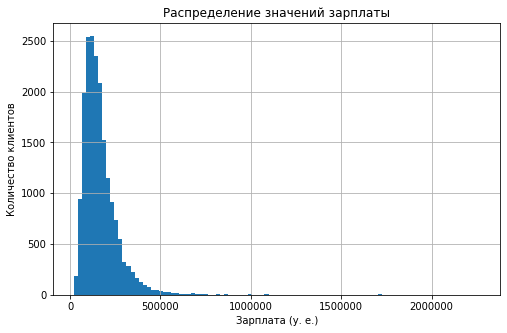

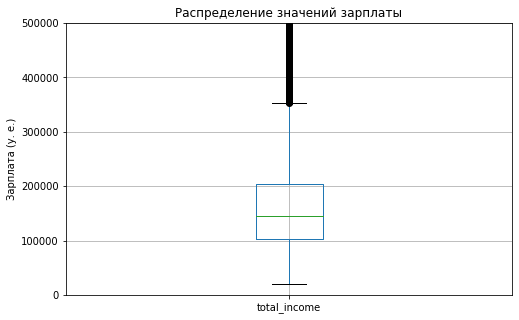

In [36]:
# вывод сводной статистики
print(debt['total_income'].describe())

# построение гистограммы
plt.figure(figsize=(8, 5))
plt.hist(debt['total_income'], bins=100)
plt.title('Распределение значений зарплаты')
plt.xlabel('Зарплата (у. е.)')
plt.ylabel('Количество клиентов')
plt.grid()
plt.show()

# построение боксплот
plt.figure(figsize=(8, 5))
debt['total_income'].plot(kind='box')
plt.title('Распределение значений зарплаты')
plt.ylabel('Зарплата (у. е.)')
plt.ylim([0, 500000]) # ограничение диапазона
plt.grid()
plt.show()

Обозначим следующие категории:
- Доход **ниже среднего** - меньше 80 тыс. у. е.
- **Средний** доход - от 80 тыс. у. е. до 200 тыс. у. е.
- Доход **выше среднего** - от 200 тыс. у. е. и выше

In [37]:
def categorize_income(income):
    """Функция присваивает значению дохода соответствующую категорию."""
    try: 
        if income < 80000:
            return 'ниже среднего'
        elif 80000 <= income < 200000:
            return 'средний'
        else:
            return 'выше среднего'
    except:
        return ('Значение income должно быть числом!')

# проверка работы функции
print(categorize_income(63000))
print(categorize_income(156000))
print(categorize_income(587032))
print(categorize_income('проверка'))

ниже среднего
средний
выше среднего
Значение income должно быть числом!


Функция работает, применим её к датафрейму:

In [38]:
# применим функцию и посмотрим результат
debt['income_group'] = debt['total_income'].apply(categorize_income)
debt.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group,child_group,income_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,недвижимость,есть дети,выше среднего
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,есть дети,средний
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,недвижимость,нет детей,средний
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,есть дети,выше среднего
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,нет детей,средний


## Шаг 2. Вывод

#### 2.1. Приведение данных к единому регистру
- Все данные типа object приведены к единообразному виду: в написании используются только строчные буквы.

#### 2.2. Проверка данных на правдоподобность
- **Колонка gender** - удалено наблюдение с неопределённым полом XNA.
- **Колонка children** - удалены строки с неправдоподобными значениями (-1 и 20 детей).
- **Колонка dob_years** - удалены строки с нулевым возрастом.

#### 2.3. Обработка пропусков
- Удалена полностью колонка *days_employed*, т. к. в ней содержится много отрицательных и неправдоподобных значений. Для целей задачи данная колонка не требуется.
- Удалены строки с пропусками в колонке *total_income*.

#### 2.4. Обработка дубликатов
- После предыдущих пунктов все дубликаты были удалены.

#### 2.5. Лемматизация
- Выделены следующие категории целей кредита:
 - **Недвижимость** - различные операции с жилой и коммерческой недвижимостью (покупка, обмен и др.)
 - **Автомобиль** - сделки, связанные с покупкой автомобиля
 - **Образование** - получение образования
 - **Свадьба** - проведение свадьбы
 - **Строительство и ремонт** - действия по возведению или ремонту зданий и помещений
 
#### 2.6. Категоризация
- Категоризация для **семейного положения** присутствовала в исходных данных.
- Проведена категоризация колонок, относящихся к **целям кредита**, **наличию детей**, **уровню дохода**.
- В рамках поставленной задачи было принято решение присвоить категориям текстовые, а не численные значения.

### Шаг 3. Вывод информации по группам

Для предобработанных данных необходимо вывести следующую информацию:

- Процент должников в зависимости от **наличия детей**
- Процент должников в зависимости от **семейного статуса**
- Процент должников в зависимости от **целей кредита**
- Процент должников в зависимости от **группы дохода**

Для каждого случая можно сделаем выводы относительно доли должников для групп.  
***ВНИМАНИЕ!*** Мы говорим лишь о предобработанных **выборочных** данных и не экстраполируем выводы на всю генеральную совокупность.

In [39]:
def show_debt_pct(df_name, col_name, title_name):
    
    """Для выбранной колонки функция выводит таблицу с процентом должников по группам:
    - df_name - наименование датафрейма;
    - col_name - наименование колонки (в кавычках);
    - title_name - наименование группы для заголовка."""
    
    # группировка
    group = pd.concat([df_name.groupby(col_name)['debt'].count(),
                       df_name.groupby(col_name)['debt'].sum()], axis=1)
    group.columns = ['total', 'debt']
    
    # расчёт колонки с процентом должников
    group['debt_pct'] = round(group['debt'] / group['total'] * 100, 2)
    # сортировка для отражении на графике
    group.sort_values('total', ascending=False, inplace=True)
    
    # построение barchart
    group_name = group.index.values
    plt.figure(figsize=(8, 5))
    plt.bar(group_name, group['total'], label='нет долга')
    plt.bar(group_name, group['debt'], bottom=group['total'], label='долг')
    plt.ylabel('Количество клиентов')
    plt.title(f'Положение с задолженностью ({title_name})')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    
    return group

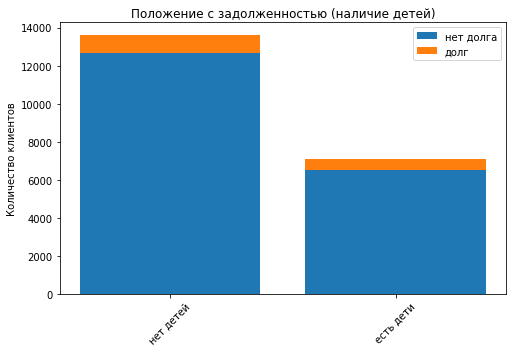

,total,debt,debt_pct
child_group,,,
нет детей,12648,947,7.49
есть дети,6501,607,9.34


In [40]:
# наличие детей
show_debt_pct(debt, 'child_group', 'наличие детей')

- В банк чаще обращались клиенты, не имеющие детей.
- Процент должников **с детьми** несколько **выше** - 9.34%, чем для клиентов **без детей** - 7.49%.

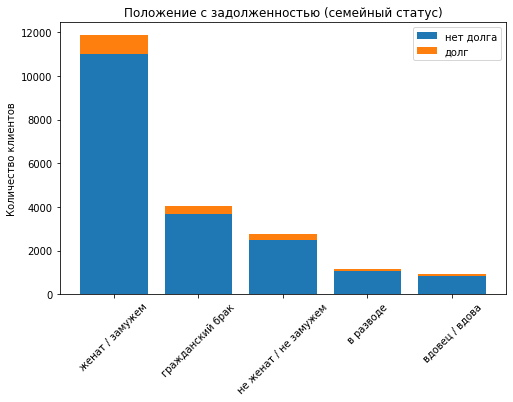

,total,debt,debt_pct
family_status,,,
женат / замужем,11026,838,7.60
гражданский брак,3700,334,9.03
не женат / не замужем,2500,252,10.08
в разводе,1069,75,7.02
вдовец / вдова,854,55,6.44


In [41]:
# семейный статус
show_debt_pct(debt, 'family_status', 'семейный статус')

- Большинство клиентов находятся в **официальном браке**.
- **Наибольшая** доля должников для группы "не женат / не замужем" - **10.08%**, **наименьшая** - для группы "вдовец / вдова" - **6.44%**.

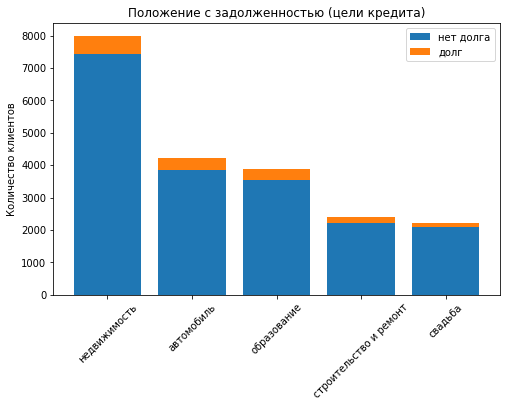

,total,debt,debt_pct
purpose_group,,,
недвижимость,7441,547,7.35
автомобиль,3851,361,9.37
образование,3557,330,9.28
строительство и ремонт,2223,163,7.33
свадьба,2077,153,7.37


In [42]:
# цели кредита
show_debt_pct(debt, 'purpose_group', 'цели кредита')

- Чаще всего целью кредита являлись операции с **недвижимостью**.
- Наиболее **высокая** доля должников в группах "автомобиль" и "образование" - **порядка 9%**.

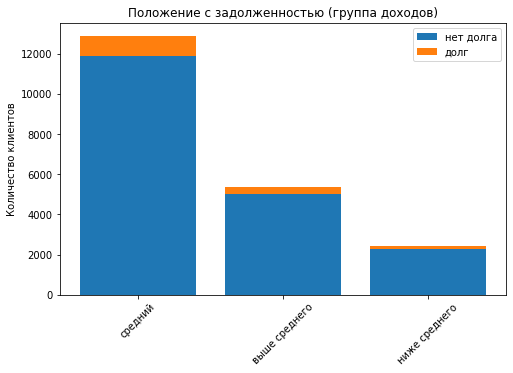

,total,debt,debt_pct
income_group,,,
средний,11885,1025,8.62
выше среднего,5011,355,7.08
ниже среднего,2253,174,7.72


In [43]:
# группа дохода
show_debt_pct(debt, 'income_group', 'группа доходов')

- Большинство клиентов имеет средний доход от 80 тыс. у. е. до 200 ты. у. е.
- Процент должников во всех группах относительно одинковый.

## Шаг 3. Вывод
- По каждой группе выведена **табличная** и **графическая** информация по ситуации с должниками.
- Важно отметить, что выводы делались относительно предобработанных **выборочных** данных, а не всей генеральной совокупности.

#### Наличие детей
- В банк чаще обращались клиенты, не имеющие детей.
- Процент должников **с детьми** несколько **выше** - 9.34%, чем для клиентов **без детей** - 7.49%.

#### Семейный статус
- Большинство клиентов находятся в **официальном браке**.
- **Наибольшая** доля должников для группы "не женат / не замужем" - **10.08%**, **наименьшая** - для группы "вдовец / вдова" - **6.44%**.

#### Цели кредита
- Чаще всего целью кредита являлись операции с **недвижимостью**.
- Наиболее **высокая** доля должников в группах "автомобиль" и "образование" - **порядка 9%**.

#### Группа дохода
- Большинство клиентов имеет средний доход от 80 тыс. у. е. до 200 ты. у. е.
- Процент должников во всех группах относительно одинковый.

# Итоговый вывод

## Шаг 1. Открытие и изучение файла
- Исходные данные содержали информацию по **21525 займам**, а также **12 колонок** - различные социально-экономические характеристики клиента и статус возврата долга.
- В таблице содержались **пропуски** и **дубликаты**, а также аномальные значения в колонках *days_employed*, *gender*, *dob_years*, *children*.

## Шаг 2. Предобработка данных
- Все данные типа object приведены к единообразному виду: в написании используются **только строчные буквы**.
- Выявлены и удалены все **аномальные значения**.
- Удалена колонка, *days_employed*, содержавшая много отрицательных и неправдоподобных значений. Также удалены строки с пропусками в колонке *total_income*.
- В результате **лемматизации** выделены группы целей кредита: недвижимость, автомобиль, образование, свадьба, строительство и ремонт.
- Проведена категоризация колонок, относящихся к **целям кредита**, **наличию детей**, **уровню дохода**.

## Шаг 3. Вывод информации по группам
- По каждой группе выведена **табличная** и **графическая** информация по ситуации с должниками.
- Важно отметить, что выводы делались относительно предобработанных **выборочных** данных, а не всей генеральной совокупности.